Libraries Imported Successfully!
Data Loaded: 80000 rows, 26 columns
--- Applying PII Masking ---
PII Masking Complete. Sensitive columns removed.


,credit_sco,gender,age,occupation,balance,monthly_ir,address,origin_province,tenure_ye,married,nums_card,nums_service,active_member,last_active_date,last_transaction_month,created_date,exit,customer_segment,engagement_score,loyalty_level,digital_behavior,risk_score,risk_segment,cluster_group,masked_full_name,masked_id
0,725,male,55,Chủ Doanh nghiệp nhỏ,177306004,121000000,Phường An Hội (BT),TP. Hồ Chí Minh,0,2,4,8,True,3/4/2025,91038993,27/02/2025,False,Priority,90,Bronze,mobile,0.0359,Low,4,d26cc74347,1
1,689,male,45,Nội trợ/Sinh viên,1927416,5000000,Phường Bến Thành (Q1),Đồng Nai,3,1,3,2,True,14/05/2025,3255569,29/07/2021,False,Mass,63,Gold,mobile,0.2664,Low,2,1977749f2b,2
2,702,female,44,Chủ Doanh nghiệp nhỏ,304931745,109000000,Phường Hòa Bình (Q11),TP. Hồ Chí Minh,4,0,2,8,False,10/9/2021,0,3/3/2021,False,Priority,36,Silver,offline,0.1343,Low,4,b57f62d97b,3


/tmp/ipython-input-3258009957.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='exit', data=df_clean, palette='viridis')


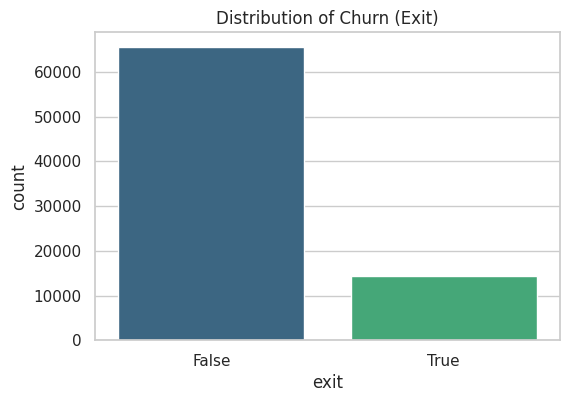

Tỷ lệ rời bỏ (Churn Rate) trung bình: 18.00%


/tmp/ipython-input-3258009957.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_by_balance.index, y=churn_by_balance.values, palette='magma')


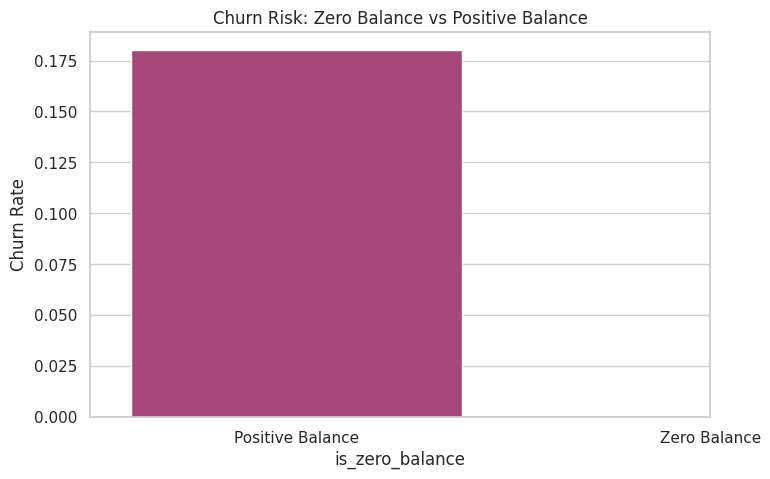

Churn Rate - Zero Balance: 0.00%
Churn Rate - Positive Balance: 18.00%


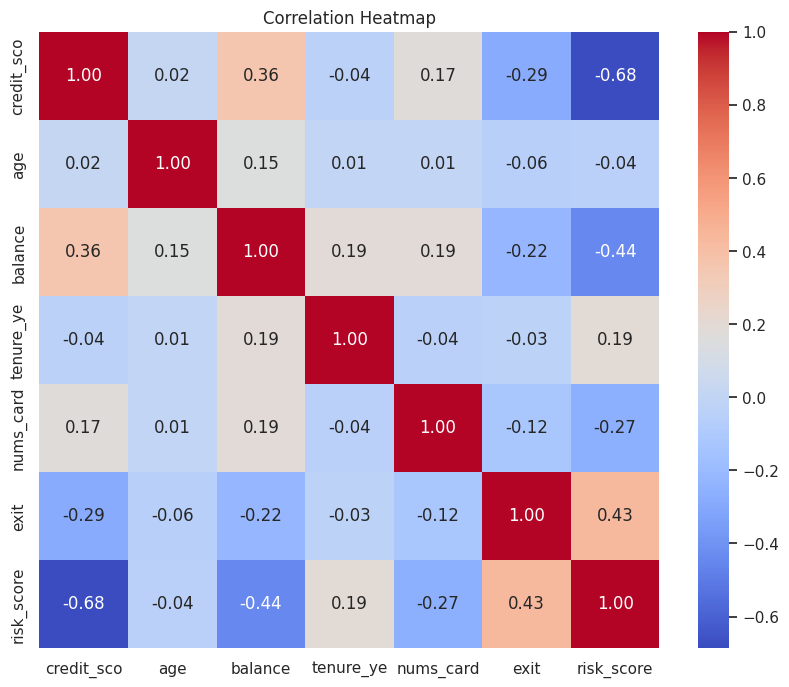

Data Preprocessing Complete. Ready for Modeling.
--- MODEL PERFORMANCE REPORT ---
Accuracy: 0.8344
ROC-AUC Score: 0.8432

Classification Report:

              precision    recall  f1-score   support

       False       0.86      0.96      0.90     13120
        True       0.59      0.27      0.37      2880

    accuracy                           0.83     16000
   macro avg       0.72      0.61      0.64     16000
weighted avg       0.81      0.83      0.81     16000



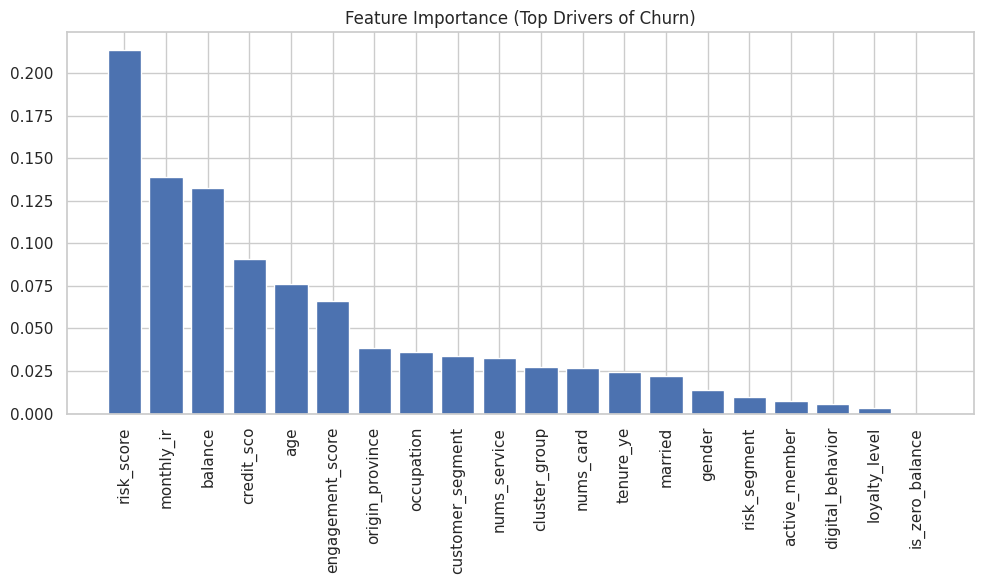

Generating Report File...
Đã xuất file: 'High_Risk_Churn_Segment.csv' chứa danh sách khách hàng cần chăm sóc đặc biệt.


In [ ]:
# @title 1. Setup & Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hashlib # Để mã hóa PII
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

# Cấu hình hiển thị
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries Imported Successfully!")

# @title 2. Load Data & PII Masking (Data Cleaning)
# Giả sử file Vietnam_Bank_Churn.csv đã được upload lên Colab
try:
    df = pd.read_csv('Vietnam_Bank_Churn.csv')
    print(f"Data Loaded: {df.shape[0]} rows, {df.shape[1]} columns")
except FileNotFoundError:
    print("⚠️ Cảnh báo: Không tìm thấy file 'Vietnam_Bank_Churn.csv'. Hãy upload file lên Colab.")
    # Tạo data giả lập chỉ để demo code chạy được (Bạn có thể xóa phần else này khi chạy thật)
    df = pd.DataFrame()

if not df.empty:
    # --- XỬ LÝ SƠ BỘ DỰA TRÊN MÔ TẢ CỦA BẠN ---
    # tenure_ye -> Tenure Years (Thâm niên khách hàng)
    # monthly_ir -> Khả năng là Monthly Interest Rate hoặc Income Revenue. Sẽ coi là biến số thực (float).
    # married -> Categorical (0,1,2,3).

    # 1. PII MASKING (Che giấu thông tin nhạy cảm)
    # Logic: Giữ lại 1 phần ID để đối soát, Hash tên khách hàng

    def mask_name(name):
        if pd.isna(name): return "Unknown"
        # Mã hóa tên thành chuỗi hash để ẩn danh hoàn toàn nhưng vẫn phân biệt được các khách hàng khác nhau
        return hashlib.sha256(str(name).encode()).hexdigest()[:10]

    def mask_id(customer_id):
        # Giữ 4 số cuối, che phần đầu
        s_id = str(customer_id)
        if len(s_id) > 4:
            return '*' * (len(s_id) - 4) + s_id[-4:]
        return s_id

    print("--- Applying PII Masking ---")
    df['masked_full_name'] = df['full_name'].apply(mask_name)
    df['masked_id'] = df['id'].apply(mask_id)

    # Loại bỏ cột gốc nhạy cảm để đảm bảo privacy compliance
    df_clean = df.drop(columns=['full_name', 'id'])

    print("PII Masking Complete. Sensitive columns removed.")
    display(df_clean.head(3))

# @title 3. Exploratory Data Analysis (EDA) - Tìm kiếm Insight
if not df.empty:
    # 3.1 Kiểm tra phân phối Churn (Exit)
    plt.figure(figsize=(6, 4))
    sns.countplot(x='exit', data=df_clean, palette='viridis')
    plt.title('Distribution of Churn (Exit)')
    plt.show()

    churn_rate = df_clean['exit'].mean() * 100
    print(f"Tỷ lệ rời bỏ (Churn Rate) trung bình: {churn_rate:.2f}%")

    # 3.2 Deep Dive: Zero Balance & Urban Insight (ĐÃ SỬA LỖI KEYERROR)

    # BƯỚC QUAN TRỌNG: Ép kiểu cột balance về số thực để tránh lỗi so sánh
    df_clean['balance'] = pd.to_numeric(df_clean['balance'], errors='coerce').fillna(0)

    # Tạo cột định danh Zero Balance
    df_clean['is_zero_balance'] = df_clean['balance'].apply(lambda x: 1 if x == 0 else 0)

    # Tính toán tỷ lệ Churn theo nhóm
    churn_by_balance = df_clean.groupby('is_zero_balance')['exit'].mean()

    plt.figure(figsize=(8, 5))
    if not churn_by_balance.empty:
        sns.barplot(x=churn_by_balance.index, y=churn_by_balance.values, palette='magma')
        plt.xticks([0, 1], ['Positive Balance', 'Zero Balance'])
        plt.ylabel('Churn Rate')
        plt.title('Churn Risk: Zero Balance vs Positive Balance')
        plt.show()

    # SỬ DỤNG .get() ĐỂ TRÁNH LỖI KEYERROR NẾU THIẾU DỮ LIỆU
    # Nếu không có key 1 (không có ai balance=0), nó sẽ trả về 0 thay vì báo lỗi
    rate_zero = churn_by_balance.get(1, 0) * 100
    rate_pos = churn_by_balance.get(0, 0) * 100

    print(f"Churn Rate - Zero Balance: {rate_zero:.2f}%")
    print(f"Churn Rate - Positive Balance: {rate_pos:.2f}%")

    # 3.3 Phân tích Correlation Matrix (Ma trận tương quan)
    # Chọn các cột số để xem tương quan
    numeric_cols = ['credit_sco', 'age', 'balance', 'tenure_ye', 'nums_card', 'exit', 'risk_score']
    # Fill NA nếu có để vẽ biểu đồ
    corr = df_clean[numeric_cols].fillna(0).corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Heatmap')
    plt.show()

# @title 4. Feature Engineering & Preprocessing for Model
if not df.empty:
    # Xử lý các biến Categorical (Biến chữ -> Số)
    # 'gender', 'occupation', 'origin_province', 'customer_segment', 'digital_behavior'

    # Dùng Label Encoding cho đơn giản trong baseline model
    le = LabelEncoder()
    categorical_cols = ['gender', 'occupation', 'origin_province', 'customer_segment',
                        'digital_behavior', 'risk_segment', 'active_member', 'loyalty_level']

    df_model = df_clean.copy()

    # Xử lý ngày tháng: Chuyển đổi thành số ngày từ khi active lần cuối hoặc bỏ qua cho baseline
    # Ở đây ta sẽ bỏ qua các cột ngày tháng phức tạp cho model baseline để tránh lỗi data
    drop_date_cols = ['last_active_date', 'last_transaction_month', 'created_date', 'address', 'masked_full_name', 'masked_id']
    df_model = df_model.drop(columns=[c for c in drop_date_cols if c in df_model.columns])

    for col in categorical_cols:
        if col in df_model.columns:
            df_model[col] = df_model[col].astype(str) # Chuyển về string để tránh lỗi type
            df_model[col] = le.fit_transform(df_model[col])

    # Fill NA cho các cột số còn lại
    df_model = df_model.fillna(0)

    # Tách biến mục tiêu
    X = df_model.drop('exit', axis=1)
    y = df_model['exit'] # True/False hoặc 0/1

    # Chia tập train/test (80/20)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Chuẩn hóa dữ liệu (Standard Scaler) - Tốt cho Logistic Regression
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print("Data Preprocessing Complete. Ready for Modeling.")

# @title 5. Build Baseline Churn Prediction Model (Random Forest)
if not df.empty:
    # Sử dụng Random Forest vì nó xử lý tốt dữ liệu phi tuyến tính và cho biết Feature Importance
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_test)
    y_prob = rf_model.predict_proba(X_test)[:, 1]

    # Đánh giá Model
    print("--- MODEL PERFORMANCE REPORT ---")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")
    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred))

    # Feature Importance (Yếu tố nào ảnh hưởng nhất đến Churn?)
    importances = rf_model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 6))
    plt.title("Feature Importance (Top Drivers of Churn)")
    plt.bar(range(X.shape[1]), importances[indices], align="center")
    plt.xticks(range(X.shape[1]), [X.columns[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()

# @title 6. Export Insights Report
if not df.empty:
    # Tạo bảng tổng hợp Insights để xuất Excel
    # Ví dụ: Nhóm khách hàng rủi ro cao nhất
    high_risk_customers = df_clean[df_clean['risk_score'] > df_clean['risk_score'].quantile(0.8)]

    print("Generating Report File...")
    # Xuất ra CSV
    high_risk_customers.to_csv('High_Risk_Churn_Segment.csv', index=False)
    print("Đã xuất file: 'High_Risk_Churn_Segment.csv' chứa danh sách khách hàng cần chăm sóc đặc biệt.")

Để xác minh điều này, chúng ta có thể kiểm tra các giá trị duy nhất và số lượng của cột `is_zero_balance` sau khi nó được tạo:

In [4]:
if not df.empty:
    # Đảm bảo cột balance đã được xử lý như trong bước 3.2
    df_clean['balance'] = pd.to_numeric(df_clean['balance'], errors='coerce').fillna(0)
    df_clean['is_zero_balance'] = df_clean['balance'].apply(lambda x: 1 if x == 0 else 0)

    print("Giá trị và số lượng của cột 'is_zero_balance':")
    display(df_clean['is_zero_balance'].value_counts())
    print("\nNếu chỉ có một giá trị '0' hiển thị, điều đó có nghĩa là không có khách hàng nào có số dư bằng 0 sau quá trình làm sạch dữ liệu.")
else:
    print("DataFrame df trống. Vui lòng tải dữ liệu trước.")

Giá trị và số lượng của cột 'is_zero_balance':


,count
is_zero_balance,
0,80000



Nếu chỉ có một giá trị '0' hiển thị, điều đó có nghĩa là không có khách hàng nào có số dư bằng 0 sau quá trình làm sạch dữ liệu.
